## Agents

Autogen Agentchat provides various agents that are capable of reacting differently.

The common components are
1. name
2. description
3. run :
   - A method that runs the **task** given to the agent.
   - Task is given as a **string** or **list of messages**.
   - Returns a **TaskResult**
   - Agents are expected to be stateful and this method is expected to be called with new messages, not complete history.
   - Refer to below img on what **stateful** means. So effectively, only new messages are passed to the run method as Agents remember the history themselves.
4. run_stream : Same as run but
   - returns an iterator of messages (BaseAgentEvent or BaseChatMessage).
   - Followed by TaskResult as the last item.

### <u>Comment on statefulness of agents</u>

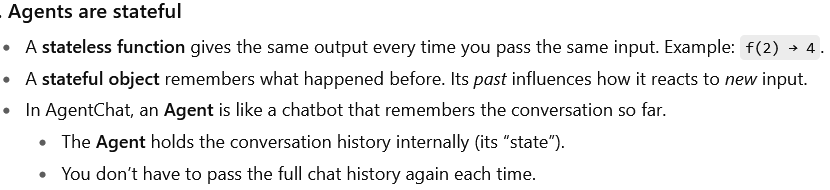

## Assistant Agent

Uses LLMs and has ability to use Tools.

**note**: This is a very general agent for educational purposes to understand all options. Ideally, once you understand then implement your own agent via [Custom Agent](https://microsoft.github.io/autogen/stable//user-guide/agentchat-user-guide/custom-agents.html)

### Base Assistant Agent ex (already seen in quickstart. Pasting for completion purposes - skip if revising)

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4.1-nano",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [4]:
# Use asyncio.run(agent.run(...)) when running in a script.
result = await agent.run(task="Find information on AutoGen")
print(result.messages)

[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 19, 12, 44, 54, 854382, tzinfo=datetime.timezone.utc), content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=47), metadata={}, created_at=datetime.datetime(2025, 8, 19, 12, 44, 59, 448879, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_WhOR6ddx50zJa0GkgsvmBhzj', arguments='{"query": "AutoGen"}', name='web_search'), FunctionCall(id='call_RT72yTt4oRLQDXpKtJW78NzY', arguments='{"query": "AutoGen software"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 19, 12, 44, 59, 450289, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call

In [11]:
[type(i) for i in result.messages]

[autogen_agentchat.messages.TextMessage,
 autogen_agentchat.messages.ToolCallRequestEvent,
 autogen_agentchat.messages.ToolCallExecutionEvent,
 autogen_agentchat.messages.ToolCallSummaryMessage]

In [12]:
result.messages[-1].content

'AutoGen is a programming framework for building multi-agent applications.\nAutoGen is a programming framework for building multi-agent applications.'

So we saw above
* RUN - returned a list of messages
* This includes the input msg, internal agent events and then output message

All this is stored in **.messages** - think of this storing **thought process** of the agent

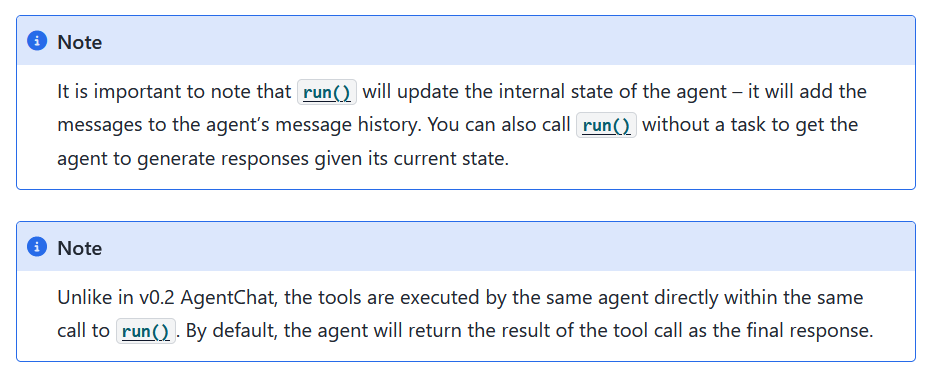